# Non linear analysis - Assignment 4

01.11.2023 - Jérémie Engler and Laure Toullier

Part 4 - Euler Backward method

In [740]:
#imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import math
import pandas as pd

np.set_printoptions(precision=5, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

General data

In [741]:
E = 200e3 #Mpa
poisson = 0

eps_0 = np.zeros((2,))
sigma_0 = np.zeros((2,))
sigma_y=400.0 #yield stress in MPa

strain_incr = np.array([0.003,0.004])

#Constitutive matrix for plane stress:
d = E/(1 - poisson**2) #Factor of the constitutive matrix

D = np.full((2,2), poisson)
np.fill_diagonal(D, 1)
D = D * d
print(D)

[[200000.      0.]
 [     0. 200000.]]


Plane condition

In [742]:
def stress_incr_computation(strain_incr, plastic_strain_incr, n, D):
    if plastic_strain_incr.all() == 0:
        stress_incr = D @ strain_incr
    else:
        stress_incr = (D - (D @ n.T @ n @ D) / (n @ D @ n.T)) @ plastic_strain_incr
        correction_factor = (D @ n.T @ n @ D) / (n @ D @ n.T)
        trial_factor = D

    return stress_incr


def stress_for_initial_strain(strain_incr, D): # Stress increment from strain increment
    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr

    return stress_0

def strain_decomposition(strain_incr, alpha):
    elastic_strain_incr = alpha * strain_incr
    plastic_strain_incr = (1 - alpha) * strain_incr
    total_strain_incr=elastic_strain_incr+plastic_strain_incr

    return elastic_strain_incr, plastic_strain_incr,total_strain_incr

Von Mises yield criterion

In [743]:
def f (vector, sigma_y):
    fa=vector[0]**2+vector[1]**2-vector[0]*vector[1]-sigma_y**2
    return fa

Trial stress increment

In [744]:
#stress trial

def stress_trial (stress,D, strain_incr):
    stress_trial_=stress+D@strain_incr
    return stress_trial_

In [745]:
#test trial
strial=stress_trial (sigma_0,D, strain_incr)
f_trial=f(strial, sigma_y)
stress_0=strial
f0=f_trial
print(f'strial={strial}')
print(f'ftrial={f_trial}')

strial=[600. 800.]
ftrial=360000.0


In [746]:
#check of failure condition
if f_trial<0:
    print("Elastic state for the trial stress increment")
if f_trial==0:
    print("Failure at trial stress increment")
else:
    print("Not acceptable, plastic deformations occur ")
    alpha=np.sqrt((sigma_y**2)/(strial[0]**2+strial[1]**2-strial[0]*strial[1]))
    elastic_strain_incr, plastic_strain_incr,total_strain_incr=strain_decomposition(strain_incr, alpha)
   
print(f'elastic strain={elastic_strain_incr}')
print(f'plastic strain={plastic_strain_incr}')
print(f'total strain={total_strain_incr}')


Not acceptable, plastic deformations occur 
elastic strain=[0.00166 0.00222]
plastic strain=[0.00134 0.00178]
total strain=[0.003 0.004]


Euler backward method

In [747]:
#f derivated by stress (gradient of the yield surface)

def norm_criterion_surface(stress):
    n=np.zeros((2))
    n[0] = 2 * stress[0] - stress[1]
    n[1] = 2 * stress[1] - stress[0]
    return n

In [748]:
#stress derived by incr_lambda

def fd_stress_d_lambda (E, stress, incr_lambda):
    ds_dl=np.zeros((2))
    ds_dl[0]= (E*(stress[1]-3*(E**2)*stress[1]*(incr_lambda**2)-2*stress[0]*(1+3*E*incr_lambda*(1+E*incr_lambda)))/(((1+E*incr_lambda)**2)*(1+3*E*incr_lambda)**2))
    ds_dl[1]= (E*(stress[0]-3*(E**2)*stress[0]*(incr_lambda**2)-2*stress[1]*(1+3*E*incr_lambda*(1+E*incr_lambda)))/(((1+E*incr_lambda)**2)*(1+3*E*incr_lambda)**2))
    return ds_dl

In [749]:
#f derivated by incr_lamba using a scalar product (we get an integer)

def f_derivated_lambda (d_stress_d_lambda, d_f_d_stress):
    #f_d=d_stress_d_lambda[0]*d_f_d_stress[0,0]+d_stress_d_lambda[1]*d_f_d_stress[0,1]
    f_d=np.dot(d_f_d_stress,d_stress_d_lambda)
    return f_d

In [750]:
#increment of lambda i

def fincr_lambda_i (incr_lambda, f_d_lambda, f_of_incr_lambda):
    incr_lambda_i=incr_lambda-f_of_incr_lambda/f_d_lambda
    return incr_lambda_i

In [751]:
#stress vector at the end of the iteration i

def fstress_vector_i (stress, E, incr_lambda_i):
    stress_i=np.zeros((2))
    stress_i[0]=(stress[0]+E*incr_lambda_i*(stress[1]+2*stress[0]))/((1+E*incr_lambda_i)*(1+3*E*incr_lambda_i))
    stress_i[1]=(stress[1]+2*E*incr_lambda_i*stress[1]+E*incr_lambda_i*stress[0])/(1+4*E*incr_lambda_i+3*(E**2)*(incr_lambda_i**2))
    return stress_i

In [752]:
n=norm_criterion_surface(stress_0).reshape((2,1))
incr_lambda=(D @ n @ n.T @ D) / (n.T @ D @ n) @ plastic_strain_incr

In [753]:
#to print later
sigma1=[]
sigma2=[]

In [754]:
#Initialisation
stress=stress_0
incr_lambda_i=float(0)

sigma1.append(stress_0[0])
sigma2.append(stress_0[1])

iteration=20 #nb of iteration

#for each step i:

for i in range(iteration):

    stress_previous=stress
    incr_lambda_previous=incr_lambda_i
    
    #at step i-1
    d_f_d_stress_=norm_criterion_surface (stress_0)
    d_stress_d_lambda=fd_stress_d_lambda(E, stress_0, incr_lambda_previous)
    d_f_d_lambda=f_derivated_lambda(d_stress_d_lambda, d_f_d_stress_)
    f_lambda=f(stress_previous, sigma_y)
    
    #at step i
    incr_lambda_i=fincr_lambda_i (incr_lambda_previous, d_f_d_lambda, f_lambda)
    stress=fstress_vector_i (stress_0, E, incr_lambda_i)
    fy=f(stress,sigma_y)
    print("----")
    print(f'incr_lambda={incr_lambda_i}')
    print(f'stress={stress}')
    print(f'fy={fy}')
    print("----")

    sigma1.append(stress[0])
    sigma2.append(stress[1])

    #n=norm_criterion_surface (stress).reshape((2,1))
    #incr_lambda=(D @ n @ n.T @ D) / (n.T @ D @ n) @ plastic_strain

    if fy/f_trial < 0.0001:
        print ("Convergence is reached at step ", i)
        print(f'stress={stress}')
        print(f'fy={fy}')
        break

    if i==iteration and fy/f_trial>0.0001:
        raise ValueError("No convergence !")
 


----
incr_lambda=1.5517241379310346e-06
stress=[482.42481 585.99624]
fy=133426.16703883774
----
----
incr_lambda=2.6294216810289537e-06
stress=[419.95539 497.54535]
fy=54967.05138132212
----
----
incr_lambda=3.2429004812131066e-06
stress=[390.6605  458.55514]
fy=23749.062833355274
----
----
incr_lambda=3.554300564510527e-06
stress=[377.22836 441.07349]
fy=10461.631009876524
----
----
incr_lambda=3.7024185850521453e-06
stress=[371.14513 433.22895]
fy=4645.218492568354
----
----
incr_lambda=3.770559539838456e-06
stress=[368.40945 429.71522]
fy=2069.547992574662
----
----
incr_lambda=3.801410163489443e-06
stress=[367.18361 428.14349]
fy=923.3786999341683
----
----
incr_lambda=3.815274913380242e-06
stress=[366.63525 427.44095]
fy=412.2531185806438
----
----
incr_lambda=3.8214851064310565e-06
stress=[366.39014 427.12704]
fy=184.10780786079704
----
----
incr_lambda=3.824262539956316e-06
stress=[366.28062 426.9868 ]
fy=82.23103633735445
----
----
incr_lambda=3.825503874884392e-06
stress=[366.

In [755]:
def printgraph(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')
 

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

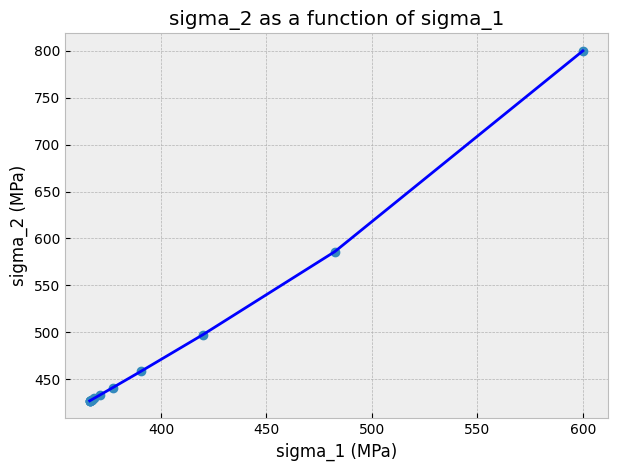

In [756]:
printgraph(sigma1,sigma2,"sigma_1","sigma_2","MPa","MPa")
